In [1]:
!pip install pandas
!pip install matplotlib
!pip install openpyxl

In [2]:
import pandas as pd
from math import *
from matplotlib.pyplot import *
from matplotlib import *

In [3]:
df = pd.read_excel("INFO_Anonyme.xlsx")
categories_a_drop_car_vides =[col for col in df if df[col].isna().all()]
print('Colonnes supprimées :', categories_a_drop_car_vides)
df = df.drop(columns=categories_a_drop_car_vides)
print(df)

Colonnes supprimées : ['Aménagement', 'Dominante (bac non réformé) - Libellé 2022/2023', 'Option facultative 4 Scolarité - Libellé 2022/2023', 'Dominante (bac non réformé) - Libellé 2021/2022', 'Option facultative 3 Scolarité - Libellé 2021/2022', 'Option facultative 4 Scolarité - Libellé 2021/2022', 'Dominante (bac non réformé) - Libellé 2020/2021', 'Option facultative 3 Scolarité - Libellé 2020/2021', 'Option facultative 4 Scolarité - Libellé 2020/2021', 'Matière - Libellé en Français pour trimestre 1', 'Statut de la matière - Libellé en Français pour trimestre 1', 'Moyenne du Candidat en Français pour trimestre 1', 'Moyenne classe Candidat en Français pour trimestre 1', 'Moyenne Basse Classe du Candidat en Français pour trimestre 1', 'Moyenne Haute Classe du Candidat en Français pour trimestre 1', 'Origine de la saisie - Libellé en Français pour trimestre 1', 'Matière - Libellé en DNL Mathématiques pour trimestre 1', 'Statut de la matière - Libellé en DNL Mathématiques pour trimestr

In [53]:
# Fonction qui permet d'afficher un graphe d'une catégorie avec conditions
# catégorie : à prendre sur excel
# minimum : affiche tout les clés qui ont + que le minimum d'étudiant, et affiche ce qui ont - du minimum dans une catégorie "autres"
# Exemple d'utilisation :
# graph_condition("Langue vivante B scolarité - Libellé 2022/2023", 100)
# show()
def graph(categorie, en_fonction_de=None, type_graph='bar', minimum=20, classement=None, df=df):

    # Si la catégorie est des Notes, faire un graphique de densité plutôt
    if(categorie[:7] == 'Moyenne'): type_graph = 'densite'
    if(type_graph == 'densite'): graph_densite(categorie)
        
    # Convertir toutes les valeurs en chaînes pour uniformiser
    str_values = df[categorie].astype(str)
    dic = str_values.value_counts()
    X_labels = dic.index.tolist()
    Y = dic.values   
    
    # Si on veut observer une catégorie en fonction d'une autre
    if(en_fonction_de != None):
        position = tab_position(categorie, en_fonction_de)
        X_labels = X_classement(categorie, X_labels, position)
        Y = Y_classement(categorie, X_labels, position)
    
    if(categorie[:7] == "Commune"):
        dep = departement(df)
        X_labels = dep[0]
        Y = dep[1]
    
    # Si on veut observer un graphique spécique sur le classement
    if classement:
        # Nécéssite deux mises à jours sur X_labels et Y (X_classement sur X_labels et pareil pour Y)
        X_labels = X_classement(categorie, X_labels, classement)
        Y = Y_classement(categorie, X_labels, classement)
        dic = pd.Series(Y, index=X_labels)

    # Mise à jour de X et Y avec les fonctions autres_X et autres_Y
    X_labels = autres_X(X_labels, Y, minimum)
    Y = autres_Y(X_labels, Y, minimum)
        
    # Supprimer les nan si c'est la barre la plus haute
    if X_labels[0] == 'nan' and Y[0] >= max(Y):
        X_labels = X_labels[1:]
        Y = Y[1:]
    
    # Remplacer 'nan' par 'Non renseigné' dans X_labels restants
    X_labels = ['Non renseigné' if label == 'nan' else label for label in X_labels]

    if (type_graph == 'bar'): return graph_bar(categorie, minimum, Y, X_labels, dic)
    if(type_graph == 'circulaire'): return graph_circulaire(Y, X_labels, dic, categorie)


# Fonction qui renvoie une liste avec +n étudiant et le reste dans 'autres' pour X
def autres_X(X, Y, n):
    tab = []
    autre_inclus = False
    for i in range(len(X)):
        if (Y[i] > n): tab.append(X[i])
        else: autre_inclus = True
    if autre_inclus: tab.append('Autre')
    return tab

    
# Fonction qui renvoie une liste avec +n étudiant et le reste dans 'autres' pour Y
def autres_Y(X, Y, n):
    tab = []
    autre = 0
    for valeur in Y:
        if (valeur > n): tab.append(valeur)
        else: autre += valeur
    if (autre > 0): tab.append(autre)
    return tab


# Fonction qui affiche spécifiquement un graphique en bâtons à partir de graph()
def graph_bar(categorie, minimum, Y, X_labels, dic):
    # Si 'Autre' est l'unique barre ou au moins 2 fois plus grande que la plus grande barre, refaire le graphique avec un minimum 2 fois plus petit
    if ('Autre' in X_labels and minimum <= 20 and len(X_labels) < 25 and (len(X_labels) == 1 or Y[-1] >= 2 * max(Y[:-1]))):
        if (minimum > 1): return graph(categorie, type_graph='bar', minimum=minimum // 2)
        else:
            print("Minimum trop petit, graphique de", categorie, "non généré.")
            return False

    # Afficher la série sans la dernière ligne d'information
    print(dic.to_string(max_rows=15))
        
    # Ajuster la taille du graphique en fonction du nombre de barres (1 à 2 fois la largeur standard)
    if len(X_labels) >= 20:
        largeur = min(6.4 * (1 + (len(X_labels) - 20) / 10), 12.8)
        figure(figsize=(largeur, 4.8))
    
    X = range(len(X_labels)) # Utiliser range(len(X_labels)) pour l'axe des X
    gca().yaxis.set_major_locator(MaxNLocator(integer=True)) # Ajuster les graduations de l'axe Y pour n'avoir que des nombres entiers

    # Mets des jolies couleurs et Autre en noir
    nbr_couleurs = len(Y) - 1 if 'Autre' in X_labels else len(Y)
    cmap = colormaps['hsv'].resampled(nbr_couleurs)
    colors = [cmap(i) for i in range(nbr_couleurs)]
    if ('Autre' in X_labels): colors.append('black')    
        
    bar(X, Y, color=colors)
    ylabel(categorie.replace('Libellé en', 'Libellé en\n'))
    xticks(ticks=X, labels=X_labels, rotation=-45, ha='left')
    return True

Terminale                                             3022
Licence                                                321
nan                                                    239
BUT                                                    145
Formations des écoles d'ingénieurs                     110
BTS - BTSA - BTSM                                       69
CPGE                                                    58
                                                      ... 
Master                                                   7
Première                                                 6
Mentions complémentaires                                 3
Licence professionnelle                                  2
DEUST                                                    2
Formations d'art, de design et du spectacle vivant       2
Etudes de santé                                          2


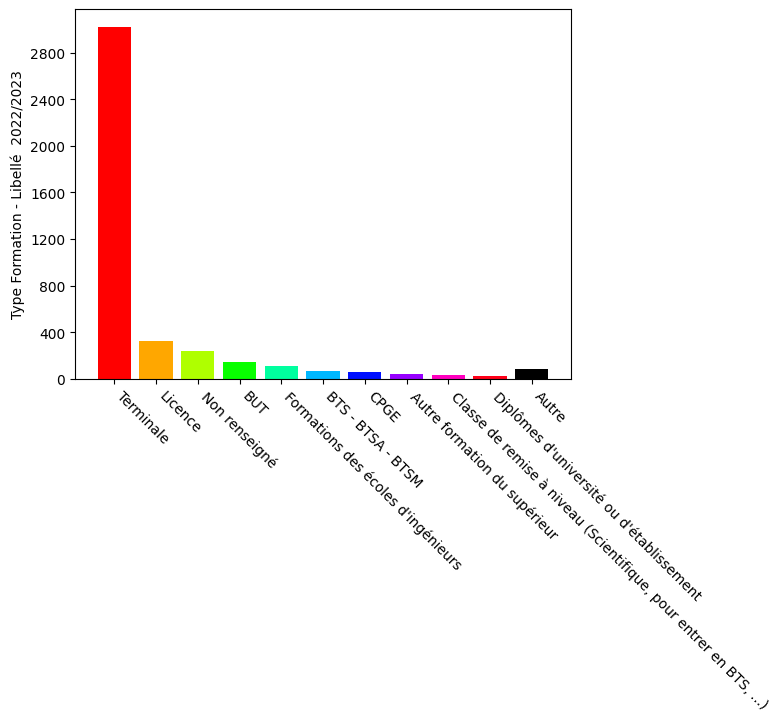

In [46]:
if graph('Type Formation - Libellé  2022/2023'): show()

In [6]:
def graph_circulaire(Y, X_labels, dic, categorie):
    print(dic.to_string(max_rows=15))
    fig, ax = subplots()
    ax.pie(Y, labels=X_labels, autopct='%1.1f%%')
    ylabel(categorie.replace('Libellé en', 'Libellé en\n'), labelpad=200)
    return True

Certifiée        3224
nan               735
Non certifiée     185


True

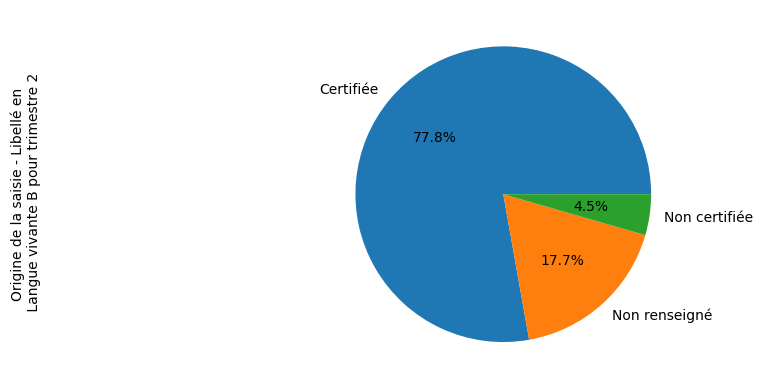

In [7]:
graph("Origine de la saisie - Libellé en Langue vivante B pour trimestre 2", type_graph='circulaire')

In [8]:
# Fonction qui retourne les positions des étudiants classé entre 1 et max d'un groupe (0 pour 7415 et 1 pour 142309)
def classement(max, code):
    G = df["Groupe candidat - Code"].value_counts()
    groupe = G.index # Créer un tableau avec les clés 7415 et 142309 de la colonne "Groupe candidat"

    C = df.loc[(df['Classement'] != 'NC') & (df['Classement'] != 'ENCF') & (df['Groupe candidat - Code'] == groupe[code])] # Supprime les NC et les ENCF de la colonne de "Classement"
    classement = C.Classement.sort_values() # Créer un tableau trié de la colonne "Classement" par ordre de Classement (premier à dernier)
    position = classement.index # Créer un tableau avec les positions de tout les étudiants classés
    return position[:max].array # tab prend les valeurs des "max" premiers valeurs du tableau de position

def X_classement(categorie, X, rang):
    tab = []
    for i in rang:
        if (df[categorie][i]) in X and (df[categorie][i] not in tab):
            tab.append(df[categorie][i])
    return tab

def Y_classement(categorie, X, rang):
    tab = []
    for i in range(len(X)) :
        nb = 0
        for j in rang:
            if(df[categorie][j] == X[i]): nb += 1
        tab.append(nb)
    return tab

Non boursier                            67
Boursier de l'enseignement scolaire     28
Boursier de l'enseignement supérieur     5


True

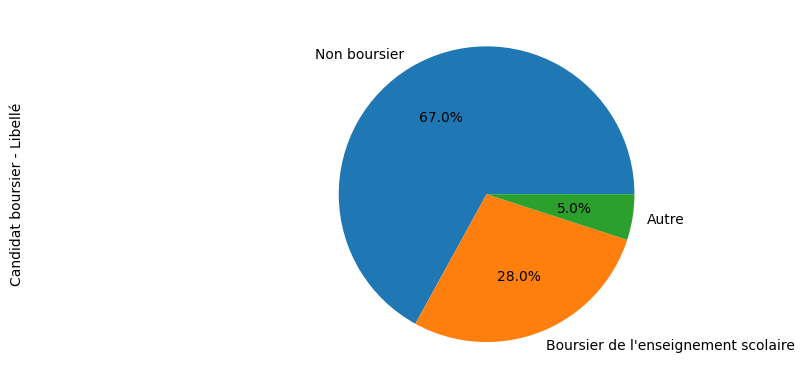

In [9]:
graph("Candidat boursier - Libellé", type_graph='circulaire', classement=classement(100,1))

In [55]:
# Histogramme de densité, utile notamment pour les notes qui sont des float entre 0 et 20
def graph_densite(categorie):
    notes = pd.to_numeric(df[categorie], errors='coerce').dropna()
    hist(notes, bins=20, density=True, alpha=0.6, color='g')
    moyenne = notes.mean()
    axvline(moyenne, color='blue', linestyle='dashed', linewidth=1)
    text(moyenne, ylim()[1], f'Moyenne: {moyenne:.2f}', ha='right', va='top', color='blue')
    xlim(0, 20)
    title(f"Densité de {categorie}")
    ylabel("Densité")
    xlabel("Notes")
    return True

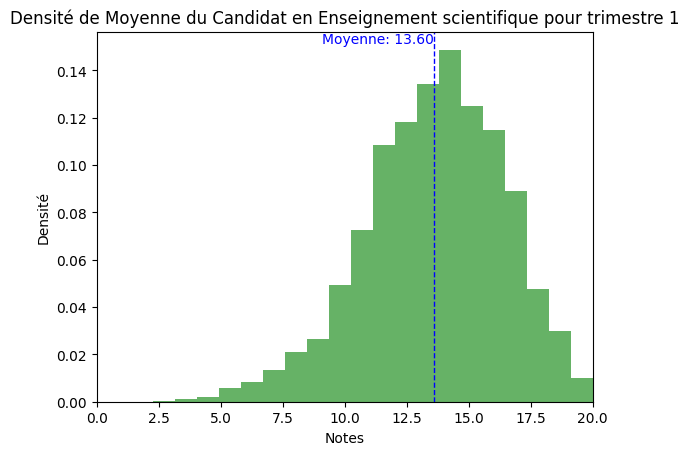

In [56]:
graph('Moyenne du Candidat en Enseignement scientifique pour trimestre 1')

In [12]:
def departement(df):
    dep_tab = [] # Tableau avec les différents départements
    dep_cpt = [] # Tableau avec le nombre d'étudiants dans chaque départements
    
    for i in range(len(df)):
        dep = str(df["Commune Etablissement origine - CodePostal 2021/2022"][i])[:2]
        if(dep not in dep_tab):
            if((dep != '0') and (dep != 'BP') and (dep != 'HA') and (dep != 'na')):
                dep_tab.append(str(df["Commune Etablissement origine - CodePostal 2021/2022"][i])[:2])
        
    for i in dep_tab :
        cpt = 0
        for j in df["Commune Etablissement origine - CodePostal 2021/2022"]:
            if(str(i) == str(j)[:2]):
                cpt += 1
        dep_cpt.append(cpt)
        
    return [dep_tab, dep_cpt]

nan      248
93200    177
93600    127
95100    112
95200     86
95140     78
93300     77
        ... 
31031      1
37000      1
51037      1
62968      1
80037      1
60128      1
62228      1


True

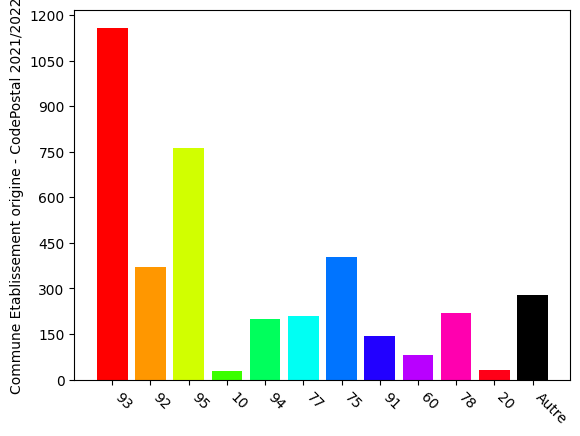

In [13]:
graph("Commune Etablissement origine - CodePostal 2021/2022")

In [47]:
def tab_position(categorie1, categorie2):
    dic = df[categorie2].value_counts()
    X = dic.index
    Y = dic.array
    rep = -1

    for i in df:
        if i == categorie2:
            for j in range(len(X)):
                print("taper", j, "pour :", X[j])
            while(int(rep) < 0 or int(rep) > len(X)):
                rep = input()
            X = [X[int(rep)]]
            Y = [Y[int(rep)]]
            print(X, Y)
            break

    position = []
    for i in range(len(df)):
        if(df[categorie2][i] == X[0]):
            position.append(i)

    return position

taper 0 pour : Masculin
taper 1 pour : Féminin
1
['Féminin'] [611]


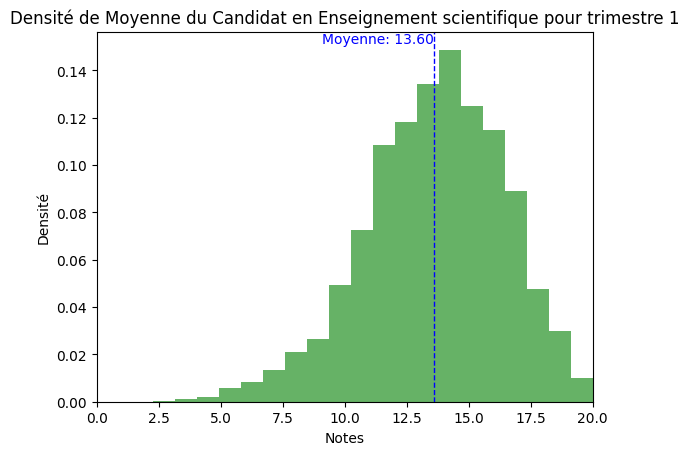

In [57]:
graph("Moyenne du Candidat en Enseignement scientifique pour trimestre 1", en_fonction_de="Sexe")

In [36]:
# Fonction qui renvoie un dictionnaire contenant les moyennes de chaques matière pour un candidat donné
def moyenne_candidat(df, position):
    position-=1
    M = df.loc[df["ID"] == position+1] # Filtre le DataFrame pour obtenir les données du candidat spécifié
    M = M.dropna(axis=1, how='all') # Supprime les colonnes vides
    matiere, moyenne = recup_donnee_candidat(M, position) # Récupère les matières et les moyennes
    dic = dict(zip(matiere, moyenne)) # Crée un dictionnaire associant chaque matière à sa moyenne
    return dic

# Fonction qui renvoie les matières et les notes d'un candidat
def recup_donnee_candidat(df, position):
    matiere, moyenne = recup_donnee_epreuve(df, position)

    # Récupération des données pour les trimestres
    trimestre_data = recup_donnee_trimestre(df, position)
    trimestre_matieres, trimestre_moyennes = trimestre_data

    # Ajout des données des trimestres aux listes matiere et moyenne
    matiere.extend(trimestre_matieres)
    moyenne.extend(trimestre_moyennes)
    
    for x in matiere:
        if "(Trimestre)" in x:
            if x[:-11]+"(Contrôle continu)" in matiere:
                le = matiere.index(x[:-11]+"(Contrôle continu)")
                matiere.pop(le)
                moyenne.pop(le)
         
    return [matiere, moyenne]

def recup_donnee_epreuve(df, position):
    # Ajoute les matières des épreuves du candidat
    matiere_epreuve = []
    # Ajoute les moyennes des épreuves du candidat, Pas de note = 0
    moyenne_epreuve = []
    for col in df:
        if col.startswith("Epreuve - Libelle"): matiere_epreuve.append(df[col][position])
        if col.startswith("Note de l'épreuve"):
            moyenne_epreuve.append(df[col][position])
            if((len(matiere_epreuve)) != len(moyenne_epreuve)):
                moyenne_epreuve.append(0) # Pas de note = 0
                
    matiere, moyenne = [], []
    # Regroupe les moyennes des 2 années (premières + terminale)
    for i in range(len(matiere_epreuve)):
        if "Moyenne générale" in matiere_epreuve[i]:a = 0
        elif matiere_epreuve[i][-1:] != ')':
            matiere.append(matiere_epreuve[i]+" (Épreuve)")
            moyenne.append(moyenne_epreuve[i])
        elif "Contrôle continu de première" in matiere_epreuve[i]:
            matiere.append(matiere_epreuve[i][:-13]+")")
            moyenne.append(float(str((moyenne_epreuve[i]+moyenne_epreuve[i+1]) / 2)[:5]))
        elif "épreuve ponctuelle de première" in matiere_epreuve[i]:
            matiere.append(matiere_epreuve[i][:-33]+" (Épreuve)")
            moyenne.append(moyenne_epreuve[i])
                
    return [matiere, moyenne]

def recup_donnee_trimestre(df, position, cible="Candidat"):
    matiere_trimestre = [col[21:-19] if col.endswith(".1") else col[21:-17] for col in df.columns if col.startswith("Matière - Libellé")]
    prefix_moyenne = "Moyenne du Candidat" if cible == "Candidat" else "Moyenne classe Candidat"
    moyenne_trimestre = [df[col][position] for col in df.columns if col.startswith(prefix_moyenne)]

    # Trouve toutes les matières de tous les trimestres et fait la somme (première + terminale)
    matiere_moyenne_dict = {}
    for matiere, moyenne in zip(matiere_trimestre, moyenne_trimestre):
        if moyenne not in ["Aucune note", "Dispensé(e)", "En attente"]:
            if matiere + " (Trimestre)" not in matiere_moyenne_dict:
                matiere_moyenne_dict[matiere + " (Trimestre)"] = [moyenne, 1]
            else:
                matiere_moyenne_dict[matiere + " (Trimestre)"][0] += moyenne
                matiere_moyenne_dict[matiere + " (Trimestre)"][1] += 1
    
    # Calculer les moyennes finales par matière
    for matiere, (somme, nb_trimestre) in matiere_moyenne_dict.items():
        if nb_trimestre != 0: matiere_moyenne_dict[matiere] = round(somme / nb_trimestre, 2)
        else: matiere_moyenne_dict[matiere] = "Aucune note"
    
    # Retourne [matiere, moyenne]
    return [list(matiere_moyenne_dict.keys()), list(matiere_moyenne_dict.values())]

In [58]:
moyenne_candidat(df, 2162)

{'Mathématiques (Épreuve)': 7.0,
 'Epreuve orale terminale dite Grand Oral (Épreuve)': 16.0,
 'Français écrit (Épreuve)': 8.0,
 'Français oral (Épreuve)': 13.0,
 'Histoire - Géographie (Contrôle continu)': 9.75,
 'Langue vivante A (Trimestre)': 11.79,
 'Langue vivante B (Trimestre)': 14.9,
 'Enseignement scientifique (Trimestre)': 12.54,
 'Mathématiques Spécialité (Trimestre)': 7.63,
 "Sciences de l'ingénieur (Trimestre)": 13.06,
 'Français (Trimestre)': 9.1}

# Classement

### Principe :
On calcule un score pour chaque étudiant, et on les trie en fonction de leur score, en ordre décroissant

### Calcul du score :
On fait la Somme du produit de leurs notes et du coefficient associé arbitrairement à la matière, puis on multiplie leur score par un modifier en fonction de certaines règles.

### Règle 1 :
On mets en **"ACM"**(À Classer Manuellement) les élèves qui ont autre chose que **"Terminale"** dans **" Niveau Etude - Libellé 2022/2023"** qui n'ont soit pas de note en Mathématiques, soit moins de 10 notes au total

In [17]:
# calcul le score d'un étudiant à l'aide des différents coéfficients sur chaques matières
def score(dic_etudiant):
    # Définit un coéfficient à chaques matières (COEFFICIENT A CHANGER)
    dic_coefficient = {"Epreuve orale terminale dite Grand Oral (Épreuve)" : 10, "Français écrit (Épreuve)" : 5,
                       "Français oral (Épreuve)" : 5, "Mathématiques (Épreuve)" : 30,
                       "Numérique et sciences informatiques (Épreuve)" : 20, "Enseignement scientifique (Épreuve)" : 20, 
                       "Langue vivante A (Épreuve)" : 10, "Histoire-Géographie (Épreuve)" : 10,
                       
                       "Langue vivante A (Contrôle continu)" : 10, "Langue vivante A (Trimestre)" : 10,
                       "Histoire - Géographie (Contrôle continu)" : 5, "Histoire-Géographie (Contrôle continu)" : 5,
                       "Mathématiques (Contrôle continu)" : 30, "Mathématiques (Trimestre)" : 30,
                       "Enseignement scientifique (Contrôle continu)" : 20, "Enseignement scientifique (Trimestre)" : 20,
                       "Langue vivante B (Trimestre)" : 5,
                       "Physique-Chimie et Mathématiques (Trimestre)" : 30, 
                       "Français (Trimestre)" : 10,
                       "Numérique et sciences informatiques (Trimestre)" : 10, 
                       "Sciences de l'ingénieur (Trimestre)" : 15,
                       "Mathématiques Spécialité (Trimestre)" : 20, 
                       "Mathématiques Expertes (Trimestre)" : 3,
                       "DNL Mathématiques Spécialité (Trimestre)" : 1, "DNL Physique-Chimie Spécialité (Trimestre)" : 1, 
                       "DNL Sciences de l'ingénieur (Trimestre)" : 1, "DNL Enseignement scientifique (Trimestre)" : 1}
    
    score = 0
    
    for i in dic_etudiant:
        if i in dic_coefficient and dic_etudiant[i] != "Aucune note":
            score += dic_etudiant[i] * dic_coefficient[i]
            
    return score

def classement_etudiant(dic, tab, position):
    # Création d'un dictionnaire pour associer les scores aux identifiants
    score_to_ids = {}
    for id in position:
        score = dic[id]["Score"]
        if score in score_to_ids: 
            score_to_ids[score].append(id)
        else: score_to_ids[score] = [id]

    tab.sort(reverse=True)

    classement = []
    for score in tab:
        # Ajout des identifiants dans le classement, tout en évitant les doublons
        if score_to_ids[score]:
            classement.append(score_to_ids[score].pop(0))

    return classement


def tableau_notes_etudiants(df):
    position = df.index
    dic = {}
    
    # Créer un dictionnaire contenant les moyennes des matières de chaques élèves (après le filtre)
    for i in position:
        dic[i] = moyenne_candidat(df, i+1)
    
    # Change la moyenne générale de chaques étudiants selon nos coefficients dans chaque matières
    tab_scores = []
    
    for i in position:
        dic[i]["Score"] = score(dic[i])
        tab_scores.append(score(dic[i]))
    
    # Attribue un classement selon leurs moyennes avec coefficient
    classement = classement_etudiant(dic, tab_scores, position)
    for i in range(len(classement)):
        dic[classement[i]]["Classement"] = i+1
    
    # Réorganise le dictionnaire afin de les trier par ordre de classement
    dic_final = {}
    
    for i in range(len(position)+1):
        for j in position:
            if(dic[j]["Classement"] == i):
                dic_final["ID "+str(j+1)] = dic[j]
                
    # Affiche les notes des étudiants sur chaques matières
    return pd.DataFrame(dic_final)

In [ ]:
# On ne prend que les candidats ayants choisi des matières de maths
C = df.loc[(df['Groupe candidat - Code'] == 142309) & (df["Epreuve - Libelle.21"] == "Mathématiques (Contrôle continu de première)") & (df["Epreuve - Libelle.22"] == "Mathématiques (Contrôle continu de terminale)") & ((df["Note de l'épreuve.3"]) >= 8)]
print(tableau_notes_etudiants(C))

In [38]:
# On ne prend que les candidats ayants choisi des matières de maths
D = df.loc[(df['Groupe candidat - Code'] == 7415) & (df["Epreuve - Libelle.1"] == "Mathématiques") & ((df["Note de l'épreuve.3"]) >= 8)]
print(tableau_notes_etudiants(D))

                                                   ID 1111  ID 2990  ID 3731  \
Mathématiques (Épreuve)                              13.00    15.00    20.00   
Epreuve orale terminale dite Grand Oral (Épreuve)    15.00    15.00    16.00   
Français écrit (Épreuve)                             12.00    17.00     7.00   
Français oral (Épreuve)                              17.00    18.00    15.00   
Histoire - Géographie (Contrôle continu)             13.90    17.20    15.85   
Enseignement scientifique (Contrôle continu)         16.65      NaN      NaN   
Langue vivante A (Trimestre)                         13.98    18.95    16.30   
Enseignement scientifique (Trimestre)                16.48    16.94    17.79   
Mathématiques Spécialité (Trimestre)                 13.53    17.59    19.83   
Mathématiques Expertes (Trimestre)                   13.17    16.17    19.47   
Langue vivante B (Trimestre)                         17.24    18.59    12.53   
Sciences de l'ingénieur (Trimestre)     

In [ ]:
graph()